In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from Models.SeEANet import SeEANet
import torch.optim as optim
import torch.nn as nn
from datetime import datetime
from utils.tools import make_datasets,make_dir

In [2]:
# 数据加载
data_Dir = "/home/admin123/SATData/data"
# 实例化数据集
emg_data, angle_data = make_datasets(data_Dir, peopleList=['S01'], exp_class="MJ", cluster_num=6, fusionMethod="PCA", windowLength=256, stepLength=1, delta_T=20)

semgData = torch.tensor(emg_data, dtype=torch.float32)
angleData = torch.tensor(angle_data, dtype=torch.float32)
print("semg 数据形状为：", semgData.shape)
print("angle 数据形状为：", angleData.shape)

dataset = TensorDataset(semgData, angleData)

# 定义划分比例
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
# 数据集分割
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

semg 数据形状为： torch.Size([26645, 6, 256])
angle 数据形状为： torch.Size([26645, 3])


In [3]:
# 初始化模型、优化器和损失函数
model = SeEANet(PreNum=3)
modelName = "SeEANet"
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
criterion = criterion.cuda()

In [5]:
formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
checkpoint_save_Dir = os.path.join("/home/admin123/SATData", "Run", modelName, formatted_time)
make_dir(checkpoint_save_Dir)
checkpoint_save_path = os.path.join(checkpoint_save_Dir,"best.pth")

best_loss = float('inf')
train_running_loss_ls = []
test_running_loss_ls = []
test_accuracies = []
for epoch in range(1, 2000+1):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_running_loss_ls.append(running_loss)

    
    # 测试模型
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss
    if epoch % 50 == 0:
        print('Epoch %d, Train Loss: %.5f, Test Loss: %.5f'%(epoch, running_loss, test_loss*4))

    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(model.state_dict(), checkpoint_save_path)

Epoch 50, Train Loss: 28882.20898, Test Loss: 27322.33008
Epoch 100, Train Loss: 242.23056, Test Loss: 174.86481
Epoch 150, Train Loss: 58.77839, Test Loss: 92.73598
Epoch 200, Train Loss: 18.82222, Test Loss: 31.06088
Epoch 250, Train Loss: 14.85092, Test Loss: 13.14749
Epoch 300, Train Loss: 13.76816, Test Loss: 12.13294
Epoch 350, Train Loss: 11.25764, Test Loss: 13.92126
Epoch 400, Train Loss: 9.71923, Test Loss: 10.61234
Epoch 450, Train Loss: 5.70646, Test Loss: 5.02487
Epoch 500, Train Loss: 13.68261, Test Loss: 22.40926
Epoch 550, Train Loss: 7.01138, Test Loss: 7.96589
Epoch 600, Train Loss: 24.23222, Test Loss: 16.44582


KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

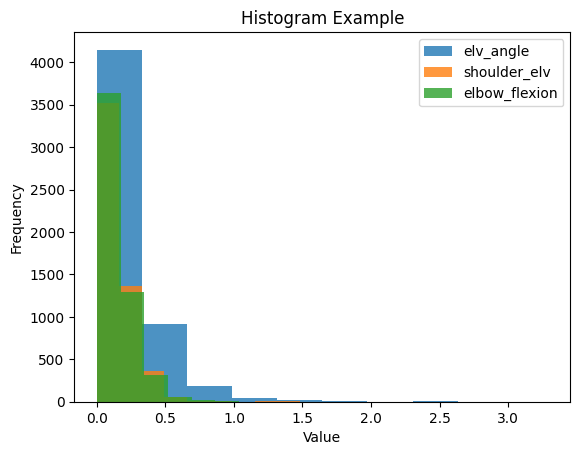

In [9]:
# 计算性能指标
import matplotlib.pyplot as plt
from Models.SeEANet import SeEANet
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 初始化模型结构
model_eval = SeEANet().cuda()
model_eval.load_state_dict(torch.load(checkpoint_save_path))

model_eval.eval()
truthAnglesList = []
preAnglesList = []
for inputs, labels in test_loader:
    truthAnglesList.append(labels)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model_eval(inputs)
    preAnglesList.append(outputs.cpu().detach().numpy())

truthAngles = np.concatenate(truthAnglesList, axis=0)
preAngles = np.concatenate(preAnglesList, axis=0)

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(np.abs(tru_angle_1-pre_angle_1), bins=10, alpha=0.8, label="elv_angle")
plt.hist(np.abs(tru_angle_2-pre_angle_2), bins=10, alpha=0.8, label="shoulder_elv")
plt.hist(np.abs(tru_angle_3-pre_angle_3), bins=10, alpha=0.8, label="elbow_flexion")
plt.legend()
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')